# Machine Learning

# Sarrigiannis Marios (mtn2116)

# Resume screening project

## Prepare project:

1. load libraries
2. load extracted CV data (produced by ResFileToCsv.py)

In [1]:
#newer nltk version is required for running the scripts
!pip uninstall nltk==3.2.5

Found existing installation: nltk 3.2.5
Uninstalling nltk-3.2.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/nltk-3.2.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/nltk/*
Proceed (y/n)? y
  Successfully uninstalled nltk-3.2.5


In [2]:
#newer nltk version is required for running the scripts
!pip install nltk==3.6.2

     |████████████████████████████████| 1.5 MB 5.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import itertools
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer,precision_score,f1_score,recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df = pd.read_csv('/content/drive/My Drive/MSC/ML/train_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    317 non-null    object
 1   label   326 non-null    object
dtypes: object(2)
memory usage: 5.2+ KB


## Data exploration

We set out to explore our data and check potential class imbalance. 

We observe (as expected) that Bad candidates are way more than Maybe or Good candidates. At first, since this is intended to be a screening system, we tried merging Maybe and Good classes, but that did not lead to better results so we will not explore that option.

In [6]:
df.head()

,text,label
0,POOJA KUDALE E-Mail: poojakudale821@gmail.com ...,Bad
1,ATHIRA P JUNIOR SOFTWARE ENGINEER E-MAIL : ath...,Bad
2,Aabid Jamil EDUCATION Bachelors Chandigarh Eng...,Bad
3,Aakash Khurange Jr. About Me My name is Aakash...,Bad
4,ABHISHEK KUMAR MISHRA B.Tech (Computer Science...,Bad


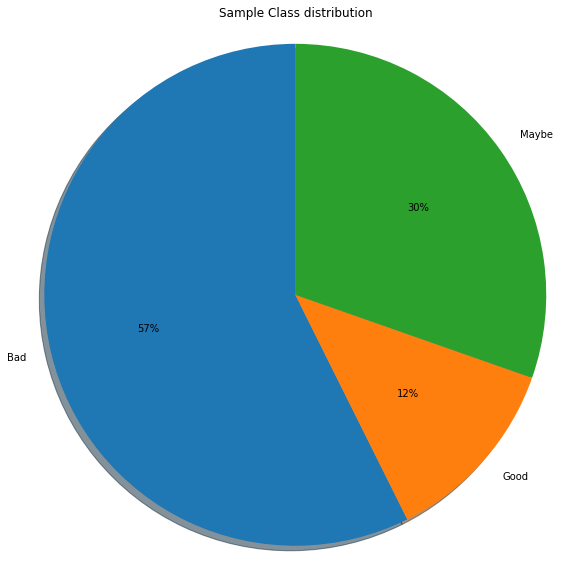

In [7]:
# Create pie chart visualization
pie = plt.figure(figsize=(10,10))
plt.pie(df.groupby('label').size(), labels=df.label.unique(), autopct='%1.0f%%',shadow=True,startangle=90)
plt.title('Sample Class distribution')
plt.axis('equal')
plt.show()

## Preprocessing:

1. drop null columns
2. make text lowercase
3. remove URLs
4. remove RT and cc
5. remove emails
6. remove punctuation

In [8]:
df.dropna()

,text,label
0,POOJA KUDALE E-Mail: poojakudale821@gmail.com ...,Bad
1,ATHIRA P JUNIOR SOFTWARE ENGINEER E-MAIL : ath...,Bad
2,Aabid Jamil EDUCATION Bachelors Chandigarh Eng...,Bad
3,Aakash Khurange Jr. About Me My name is Aakash...,Bad
4,ABHISHEK KUMAR MISHRA B.Tech (Computer Science...,Bad
...,...,...
321,Amit Kundu Student How to reach me: Cell: 9734...,Maybe
322,Veeresh Surya C Junior software Engineer phone...,Maybe
323,Vignesh N Looking for a challenging role in a ...,Maybe
324,Vikas Yadav Software Engineer A Computer Scien...,Maybe


In [9]:
def processText(text):
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('\S*@\S*\s?', '  ', text)  # remove emails
    text = re.sub('[%s]' % re.escape("""!"$%'()*,/:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.lower() #lower case

In [10]:
df['text'] = df.text.apply(lambda x: processText(str(x)))

In [11]:
df.head()

,text,label
0,pooja kudale e-mail mobile +91-9036714938 to s...,Bad
1,athira p junior software engineer e-mail phone...,Bad
2,aabid jamil education bachelors chandigarh eng...,Bad
3,aakash khurange jr. about me my name is aakash...,Bad
4,abhishek kumar mishra b.tech computer science ...,Bad


## Feature extraction

In order select which features will help in our problem, we consulted with recruiters who tell us that in the screening step of a hiring process the candidate is considered based on:

1. Their skills matching what is required for the role
2. Their education level being the highest
3. Whether or not they have studied in some exceptional universities
4. Whether or not they have worked in some exceptional companies

Based on that, we extracted our features.

First, some info is provided, specifically:

1. List of required skills
2. List of exceptional universities
3. List of exceptional companies

and candidates are scored accordingly, producing 3 features:

1. Skills score
2. Universities score
3. Companies score

As our last feature, we extract the candidates education level which may be:

* None 
* High School
* Bachelor's Degree
* Master's Degree
* Phd



After features are extracted, data is scaled using minmax scaler and in order to help overcome class imbalance, additional samples were generated using SMOTE

In [12]:
#load skills and companies list
SKILLS = list(filter(None, open('/content/drive/My Drive/MSC/ML/skills.txt').read().lower().split('\n')))
COMPANIES = list(filter(None, open('/content/drive/My Drive/MSC/ML/companies.txt').read().lower().split('\n')))

In [13]:
#universities might have first the city and then the name or vice versa
unis = filter(None, open('/content/drive/My Drive/MSC/ML/universities.txt').read().lower().split('\n'))
UNIVERSITIES = []
for uni in unis:
  for permutation in list(itertools.permutations(uni.split(','))):
    UNIVERSITIES.append(re.sub('\s+', ' ', ' '.join(permutation).strip()))

In [14]:
#list of all degrees encoded 0 = high school, 1 = bachelors, 2 = masters, 3= phd
EDUCATION = {
    'ssc': 0, 
    'hsc': 0, 
    'cbse': 0, 
    'icse': 0, 
    'xii': 0,
    'be' : 1,
    'b.e.': 1,
    'b.e': 1, 
    'bs': 1, 
    'b.s': 1, 
    'btech': 1, 
    'b.tech': 1,
    'me': 2, 
    'm.e': 2, 
    'm.e.': 2, 
    'ms': 2, 
    'm.s': 2, 
    'm.tech': 2, 
    'mtech': 2,
    'phd': 3
}

In [15]:
def scoreCandidate(text):
  #extract words
  tokens = nltk.tokenize.word_tokenize(text)

  #generate bigrams and trigrams (e.g. object oriented programming)
  ngrams = list(map(' '.join, nltk.everygrams(tokens, 2, 3)))

  skillScore = 0
  cmpScore = 0
  educationLevel = -1
  educationScore = 0

  #enumerate tokens and look for degrees/skills/companies
  for token in tokens:
    if token not in stopwords.words('english'):
      if token in SKILLS:
        skillScore += 1
      if token in COMPANIES:

        cmpScore += 1
      if token in EDUCATION:
        if EDUCATION[token] > educationLevel:
          educationLevel = EDUCATION[token]     

  #enumerate ngrams and look for companies/skills
  for ngram in ngrams:
    if ngram in SKILLS:
      skillScore += 1
    if ngram in COMPANIES:
      cmpScore += 1

  for univers in UNIVERSITIES:
    if re.search(univers, text):
      educationScore += 1
    

  return pd.Series({'skills_score': skillScore, 'education_level': educationLevel, 'education_score': educationScore, 'company_score': cmpScore})

In [16]:
df = df.merge(df.text.apply(lambda x: scoreCandidate(x)), left_index=True, right_index=True)

In [17]:
df.head()

,text,label,skills_score,education_level,education_score,company_score
0,pooja kudale e-mail mobile +91-9036714938 to s...,Bad,0,-1,0,0
1,athira p junior software engineer e-mail phone...,Bad,3,0,0,0
2,aabid jamil education bachelors chandigarh eng...,Bad,8,1,0,0
3,aakash khurange jr. about me my name is aakash...,Bad,8,0,0,0
4,abhishek kumar mishra b.tech computer science ...,Bad,0,1,0,0


In [18]:
df.describe()

,skills_score,education_level,education_score,company_score
count,326.000000,326.000000,326.000000,326.000000
mean,4.932515,0.226994,0.027607,0.233129
std,5.124456,1.083019,0.164097,0.680005
min,0.000000,-1.000000,0.000000,0.000000
25%,2.000000,-1.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,7.000000,1.000000,0.000000,0.000000
max,36.000000,2.000000,1.000000,6.000000


In [19]:
#label encoding
label_dict = {'Bad': 1, 'Good': 2, 'Maybe': 3}

df['label'] = df.label.map(label_dict)

In [20]:
Y = df['label']

#drop raw text column and label
X = df.drop('label', 1).drop('text', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [21]:
# Transform data using minmaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
rescaledX = scaler.transform(X)
# summarise transformed data
np.set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[0.    0.    0.    0.   ]
 [0.083 0.333 0.    0.   ]
 [0.222 0.667 0.    0.   ]
 [0.222 0.333 0.    0.   ]
 [0.    0.667 0.    0.   ]]


In [22]:
#oversampling using SMOTE
oversample = SMOTE()
smoteX, smoteY = oversample.fit_resample(rescaledX, Y)

In [23]:
#check that additional 
print(len(X))
print(len(smoteX))

326
561


## Algorithm selection 

Here, a plethora of Machine Learning algorithms are run and evaluated on the following metrics:

* accuracy
* f1-score

We first tried selecting our model with the oversampled data, however, algorithm performance is worse

accuracy  : 

 LR: 0.433208 (+/- 0.053361)
LDA: 0.440351 (+/- 0.038140)
kNN: 0.522337 (+/- 0.066718)
 DT: 0.613127 (+/- 0.039691)
 NB: 0.395865 (+/- 0.058232)
 RF: 0.607769 (+/- 0.042074)
SVM: 0.501003 (+/- 0.040639)
Bagging LR: 0.434994 (+/- 0.053475)
Bagging LDA: 0.445708 (+/- 0.051060)
Bagging kNN: 0.561560 (+/- 0.068309)
Bagging DT: 0.611341 (+/- 0.044812)
Bagging NB: 0.394079 (+/- 0.065265)
Bagging SVM: 0.502788 (+/- 0.040947)
Adaboost: 0.540163 (+/- 0.053469)
XGBoost: 0.573935 (+/- 0.046488)


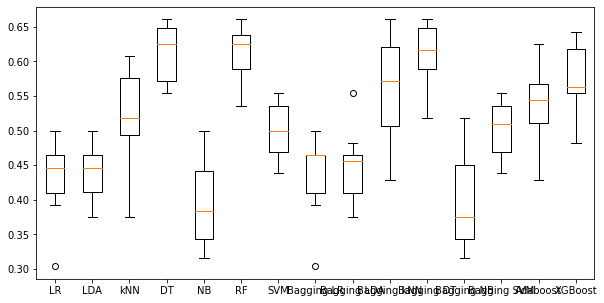

f1  : 

 LR: 0.425862 (+/- 0.060590)
LDA: 0.439843 (+/- 0.035283)
kNN: 0.514894 (+/- 0.066991)
 DT: 0.608847 (+/- 0.043469)
 NB: 0.332535 (+/- 0.074842)
 RF: 0.601867 (+/- 0.055467)
SVM: 0.492019 (+/- 0.038544)
Bagging LR: 0.429888 (+/- 0.065487)
Bagging LDA: 0.450872 (+/- 0.047293)
Bagging kNN: 0.553638 (+/- 0.067654)
Bagging DT: 0.620344 (+/- 0.042555)
Bagging NB: 0.332576 (+/- 0.071772)
Bagging SVM: 0.494628 (+/- 0.035754)
Adaboost: 0.536009 (+/- 0.054221)
XGBoost: 0.568821 (+/- 0.044671)


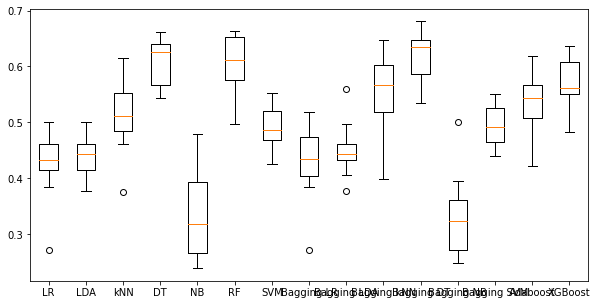

In [24]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('kNN', KNeighborsClassifier()))
models.append(('DT',  DecisionTreeClassifier()))
models.append(('NB',  GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('Bagging LR',BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100)))
models.append(('Bagging LDA',BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=100)))
models.append(('Bagging kNN',BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100)))
models.append(('Bagging DT',BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)))
models.append(('Bagging NB',BaggingClassifier(base_estimator=GaussianNB(), n_estimators=100)))
models.append(('Bagging SVM',BaggingClassifier(base_estimator=SVC(), n_estimators=100)))
models.append(('Adaboost',AdaBoostClassifier(n_estimators=100)))
models.append(('XGBoost',XGBClassifier()))

# The scoring function to use
scoring = {'accuracy' : 'accuracy',
           'f1': make_scorer(f1_score, average='weighted')}        

# We are going to evaluate all classifiers, and store results in two lists. We plot these list. 
# The process is done recursively for each score:

for cur_score in scoring:
    results = []
    names = []
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    print(cur_score, ' : \n')
    for name, model in models:        
        cv_results = cross_val_score(model, smoteX, smoteY, cv=kfold, scoring=scoring[cur_score])
        results.append(cv_results) 
        names.append(name)
        print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())) 
        
    plt.figure(figsize=(10,5))    
    plt.boxplot(results)
    plt.xticks(list(range(1,len(names)+1)), names)
    plt.show()

accuracy  : 

 LR: 0.579640 (+/- 0.068360)
LDA: 0.576420 (+/- 0.080743)
kNN: 0.573295 (+/- 0.042458)
 DT: 0.536648 (+/- 0.033806)
 NB: 0.530871 (+/- 0.115148)
 RF: 0.530587 (+/- 0.039522)
SVM: 0.585701 (+/- 0.067744)
Bagging LR: 0.582670 (+/- 0.063226)
Bagging LDA: 0.579640 (+/- 0.075551)
Bagging kNN: 0.536174 (+/- 0.053894)
Bagging DT: 0.512121 (+/- 0.060071)
Bagging NB: 0.503125 (+/- 0.104575)
Bagging SVM: 0.591761 (+/- 0.063755)
Adaboost: 0.570360 (+/- 0.073864)
XGBoost: 0.555208 (+/- 0.060055)


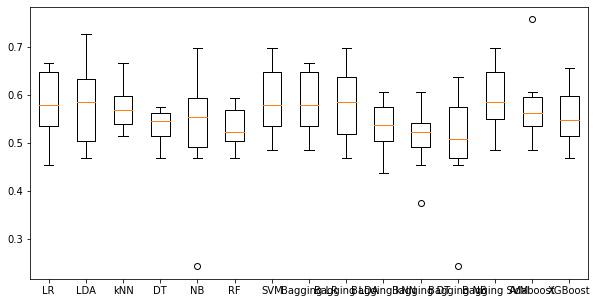

f1  : 

 LR: 0.458580 (+/- 0.084813)
LDA: 0.493521 (+/- 0.093368)
kNN: 0.500516 (+/- 0.068462)
 DT: 0.496199 (+/- 0.045673)
 NB: 0.458588 (+/- 0.137798)
 RF: 0.502731 (+/- 0.055565)
SVM: 0.462701 (+/- 0.073276)
Bagging LR: 0.460384 (+/- 0.083676)
Bagging LDA: 0.501271 (+/- 0.105883)
Bagging kNN: 0.466388 (+/- 0.063998)
Bagging DT: 0.476707 (+/- 0.046387)
Bagging NB: 0.355676 (+/- 0.119638)
Bagging SVM: 0.469967 (+/- 0.067411)
Adaboost: 0.522365 (+/- 0.094036)
XGBoost: 0.496901 (+/- 0.074682)


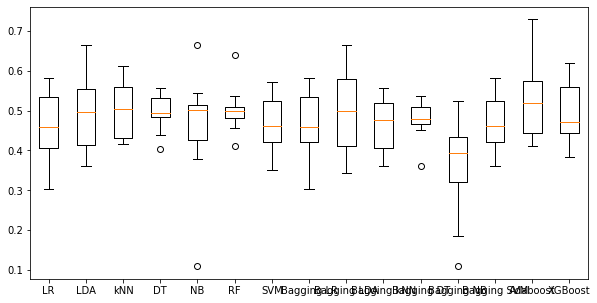

In [25]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('kNN', KNeighborsClassifier()))
models.append(('DT',  DecisionTreeClassifier()))
models.append(('NB',  GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('Bagging LR',BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100)))
models.append(('Bagging LDA',BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=100)))
models.append(('Bagging kNN',BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100)))
models.append(('Bagging DT',BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)))
models.append(('Bagging NB',BaggingClassifier(base_estimator=GaussianNB(), n_estimators=100)))
models.append(('Bagging SVM',BaggingClassifier(base_estimator=SVC(), n_estimators=100)))
models.append(('Adaboost',AdaBoostClassifier(n_estimators=100)))
models.append(('XGBoost',XGBClassifier()))

# The scoring function to use
scoring = {'accuracy' : 'accuracy',
           'f1': make_scorer(f1_score, average='weighted')}        

# We are going to evaluate all classifiers, and store results in two lists. We plot these list. 
# The process is done recursively for each score:

for cur_score in scoring:
    results = []
    names = []
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    print(cur_score, ' : \n')
    for name, model in models:        
        cv_results = cross_val_score(model, rescaledX, Y, cv=kfold, scoring=scoring[cur_score])
        results.append(cv_results) 
        names.append(name)
        print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())) 
        
    plt.figure(figsize=(10,5))    
    plt.boxplot(results)
    plt.xticks(list(range(1,len(names)+1)), names)
    plt.show()

We choose the following algorithms to train and evaluate:

* kNN
* Random Forest
* SVM

## Model Training
Apply ensembles and improve performance by hyperparameter optimisation.

In [26]:
# prepare a range of grid search
params = {'n_neighbors':[1,2,3,4,5,7,10,12,14,15],
         'weights':['uniform','distance'],
         'algorithm':['auto','ball_tree','kd_tree','brute'],
         'leaf_size':[5,10,15,20,25,30,35,40,45,50],
         'p':[1,2,3,4,5,6,7,8,9,10],
         'metric':['euclidean','manhattan','minkowski','chebyshev']}



# create and fit a kNN model, testing each param,using cv=5 cross validation sets
model = KNeighborsClassifier()
n_iter_search = 1000
grid = RandomizedSearchCV(estimator=model, param_distributions=params, scoring = make_scorer(f1_score, average='weighted'), cv=5, n_iter=n_iter_search)
start = time()
grid.fit(rescaledX, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
# summarize the results of the grid search
print(grid.best_params_) 
print(grid.best_estimator_)
print("best score: ",grid.best_score_)

RandomizedSearchCV took 26.36 seconds for 1000 candidates parameter settings.
{'weights': 'uniform', 'p': 7, 'n_neighbors': 15, 'metric': 'euclidean', 'leaf_size': 50, 'algorithm': 'brute'}
KNeighborsClassifier(algorithm='brute', leaf_size=50, metric='euclidean',
                     n_neighbors=15, p=7)
best score:  0.5246978894094931


In [27]:
# prepare a range of grid search
params = {'n_estimators': [10, 100, 1000],
          'max_features': ['sqrt', 'log2'],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False]}



# create and fit a RF model, testing each param,using cv=5 cross validation sets
model = RandomForestClassifier()
n_iter_search = 108
grid = RandomizedSearchCV(estimator=model, param_distributions=params, scoring = make_scorer(f1_score, average='weighted'), cv=5, n_iter=n_iter_search)
start = time()
grid.fit(rescaledX, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# summarize the results of the grid search
print(grid.best_params_) 
print(grid.best_estimator_)
print("best score: ",grid.best_score_)

RandomizedSearchCV took 286.17 seconds for 108 candidates parameter settings.
{'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, n_estimators=10)
best score:  0.4956247065917868


In [28]:
params = {'C': [0.1, 1, 10, 100, 1000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'kernel': ['rbf']}

# create and fit a SVM model, testing each param,using cv=5 cross validation sets
model = SVC()
n_iter_search = 25
grid = RandomizedSearchCV(estimator=model, param_distributions=params, scoring = make_scorer(f1_score, average='weighted'), cv=5, n_iter=n_iter_search)
start = time()
grid.fit(rescaledX, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# summarize the results of the grid search
print(grid.best_params_) 
print(grid.best_estimator_)
print("best score: ",grid.best_score_)

RandomizedSearchCV took 1.62 seconds for 25 candidates parameter settings.
{'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}
SVC(C=1000, gamma=0.01)
best score:  0.48376047777738174


In [29]:
params = {'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
          'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
          'algorithm': ['SAMME', 'SAMME.R']}

# create and fit a SVM model, testing each param,using cv=5 cross validation sets
model = AdaBoostClassifier()
n_iter_search = 192
grid = RandomizedSearchCV(estimator=model, param_distributions=params, scoring = make_scorer(f1_score, average='weighted'), cv=5, n_iter=n_iter_search)
start = time()
grid.fit(rescaledX, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# summarize the results of the grid search
print(grid.best_params_) 
print(grid.best_estimator_)
print("best score: ",grid.best_score_)

RandomizedSearchCV took 14.86 seconds for 192 candidates parameter settings.
{'n_estimators': 8, 'learning_rate': 0.97, 'algorithm': 'SAMME'}
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.97, n_estimators=8)
best score:  0.509578661621662


## Conclusion/Further work

In this problem we had to classify a resume as Good/Bad/Maybe. It was a classification problem. The classes was not distributed evenly, especially the Good class was heavily underepresented. <br>

* Features were extracted based on personal and expert knowledge <br>

* Several algorithms were tested, including ensembles, on different score metrics. <br>

* The nature of this problem leads us to use other metrics more appropriate than accuracy, i.e. precision and recall. In this light, the F1 score was calculated. <br>

* 3 algorithms were picked and tuned <br>

* All algorithms' f1 scores fell in the 50-53 range, which is not very good

The main part of this research was to extract meaningfull features from the resume text.

Feature extraction was based off personal experience and speaking with recruiters in one organization, who were also annotators, which may have led to mistakes.

The task is very suited to machine learning and more techniques have to be explored namely:
* Named Entity Recognition (NER) to extract universities/companies
* NLP tools to extract specific resume areas (experience, education etc.) 
* Neural Networks

The first 2 will help with feature accuracy and overcome some problems (e.g. "Oracle Cloud" will get +1 score for company Oracle).